In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from time import perf_counter
import matplotlib.pyplot as plt
from keras import layers, models
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
df = pd.read_csv('/kaggle/input/pneumonia-5-folds/train_folds.csv')

fold = 2
train_df = df[df['fold'] != fold]
val_df   = df[df['fold'] == fold]

IMG_SIZE = 224
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_dir = '/kaggle/input/pneumonia-imbalance-chest-x-ray-dataset/test'

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False 
)

Found 13801 validated image filenames belonging to 6 classes.
Found 3450 validated image filenames belonging to 6 classes.
Found 4929 images belonging to 6 classes.


In [ ]:
class NegativeImageLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(NegativeImageLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.negative(inputs)

    def get_config(self):
        config = super(NegativeImageLayer, self).get_config()
        return config

class TwiceMaxMinPooling2D(layers.Layer):
    def __init__(self, pool_size=(2, 2), strides=2, padding="SAME", **kwargs):
        super(TwiceMaxMinPooling2D, self).__init__(**kwargs)
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding

    def call(self, inputs, *args, **kwargs):
        max_pool = tf.keras.layers.MaxPooling2D(
            pool_size=self.pool_size, strides=self.strides, padding=self.padding
        )(inputs)

        neg_inputs = -inputs
        neg_max_pool = tf.keras.layers.MaxPooling2D(
            pool_size=self.pool_size, strides=self.strides, padding=self.padding
        )(neg_inputs)
        min_pool = -neg_max_pool

        return 2 * max_pool - min_pool

    def get_config(self):
        config = super().get_config()
        config.update({
            "pool_size": self.pool_size,
            "strides": self.strides,
            "padding": self.padding
        })
        return config


In [ ]:
inputs = layers.Input(shape=(224, 224, 3), name="Input")

# Block 1
x = layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu", name="Conv1")(inputs)
x = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv1")(x)
x = layers.BatchNormalization()(x)
blk1 = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool1")(x)

# Block 2
x = layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu", name="Conv2")(blk1)
x = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv2")(x)
x = layers.BatchNormalization()(x)
blk2 = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool2")(x)

# Block 3
x = layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu", name="Conv3")(blk2)
x = layers.MaxPooling2D(pool_size=2, strides=2, padding="same", name="MaxPool3")(x)
x = layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu", name="Conv4")(x)
x = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv3")(x)
x = layers.BatchNormalization()(x)
blk3 = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool4")(x)

# Block 4
x = layers.Conv2D(256, kernel_size=(3, 3), padding="same", activation="relu", name="Conv5")(blk3)
x = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool5")(x)
x = layers.Conv2D(512, kernel_size=(3, 3), padding="same", activation="relu", name="Conv6")(x)
x = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv4")(x)
blk4 = layers.BatchNormalization()(x)

# Block 5
y = NegativeImageLayer()(blk2)
y = TwiceMaxMinPooling2D(pool_size=(3, 3))(y)
y = layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu", name="Conv7")(y)
y = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool7")(y)
y = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv5")(y) 
y = layers.Conv2D(64, kernel_size=(5, 5), padding="same", activation="relu", name="Conv8")(y)
y = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool8")(y)
y = layers.Conv2D(224, kernel_size=(3, 3), padding="same", activation="relu", name="Conv9")(y)
blk5 = layers.BatchNormalization()(y)


x = layers.Concatenate(name="DirectConcat")([blk4, blk5])

x = layers.GlobalAveragePooling2D(name="GAP")(x)

outputs = layers.Dense(6, activation="softmax", name="Output")(x)

model = models.Model(inputs=inputs, outputs=outputs)

In [5]:
class CustomMetrics(tf.keras.metrics.Metric):
    def __init__(self, metric_name, **kwargs):
        super(CustomMetrics, self).__init__(name=metric_name, **kwargs)
        self.metric_name = metric_name
        self.tp = self.add_weight(name="tp", initializer="zeros")
        self.tn = self.add_weight(name="tn", initializer="zeros")
        self.fp = self.add_weight(name="fp", initializer="zeros")
        self.fn = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        y_pred = tf.round(tf.clip_by_value(y_pred, 0, 1))
        y_true = tf.round(tf.clip_by_value(y_true, 0, 1))

        self.tp.assign_add(tf.reduce_sum(y_true * y_pred))
        self.tn.assign_add(tf.reduce_sum((1 - y_true) * (1 - y_pred)))
        self.fp.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
        self.fn.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

    def result(self):
        if self.metric_name == "f1_score":
            precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
            recall = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
            return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        elif self.metric_name == "specificity":
            return self.tn / (self.tn + self.fp + tf.keras.backend.epsilon())
        elif self.metric_name == "sensitivity":
            return self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
        elif self.metric_name == "mcc":
            numerator = (self.tp * self.tn - self.fp * self.fn)
            denominator = tf.math.sqrt(
                (self.tp + self.fp) * (self.tp + self.fn) *
                (self.tn + self.fp) * (self.tn + self.fn)
            )
            return numerator / (denominator + tf.keras.backend.epsilon())
        else:
            raise ValueError(f"Unknown metric name: {self.metric_name}")

    def reset_states(self):
        self.tp.assign(0)
        self.tn.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)

def create_metrics():
    return [
        Precision(name="precision"),
        Recall(name="recall"),
        CustomMetrics(metric_name="f1_score"),
        CustomMetrics(metric_name="specificity"),
        CustomMetrics(metric_name="sensitivity"),
        CustomMetrics(metric_name="mcc"),
        AUC(name="auc"),
    ]

In [6]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'] + create_metrics()
)

In [7]:
TOTAL_EPOCHS = 25
INITIAL_LEARNING_RATE = 0.75e-4
DECAY_RATE = 0.96

def learning_rate_scheduler(epoch, current_learning_rate):
    """
    A function that returns the learning rate for each epoch.

    Args:
        epoch (int): The current epoch.
        current_learning_rate (float): The current learning rate.

    Returns:
        float: The new learning rate.
    """
    if epoch < (TOTAL_EPOCHS / 3):
        new_learning_rate = INITIAL_LEARNING_RATE
    else:
        new_learning_rate = current_learning_rate * DECAY_RATE

    return new_learning_rate

In [8]:
learning_rate_callback = LearningRateScheduler(learning_rate_scheduler)

In [9]:
start_time = perf_counter()
history = model.fit(
    train_generator,
    callbacks=[learning_rate_callback],
    validation_data=val_generator,
    epochs=TOTAL_EPOCHS,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    validation_steps=len(val_df) // BATCH_SIZE
)
end_time = perf_counter()

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


862/862 ━━━━━━━━━━━━━━━━━━━━ 144s 143ms/step - accuracy: 0.6922 - auc: 0.9055 - f1_score: 0.6083 - loss: 0.9394 - mcc: 0.5834 - precision: 0.8066 - recall: 0.5044 - sensitivity: 0.5044 - specificity: 0.9793 - val_accuracy: 0.7459 - val_auc: 0.9342 - val_f1_score: 0.7377 - val_loss: 0.8104 - val_mcc: 0.6955 - val_precision: 0.8150 - val_recall: 0.6738 - val_sensitivity: 0.6738 - val_specificity: 0.9694 - learning_rate: 7.5000e-05
Epoch 2/25
  1/862 ━━━━━━━━━━━━━━━━━━━━ 1:01 71ms/step - accuracy: 0.7500 - auc: 0.9773 - f1_score: 0.7742 - loss: 0.5845 - mcc: 0.7313 - precision: 0.8000 - recall: 0.7500 - sensitivity: 0.7500 - specificity: 0.9625

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


862/862 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7500 - auc: 0.9773 - f1_score: 0.7742 - loss: 0.5845 - mcc: 0.7313 - precision: 0.8000 - recall: 0.7500 - sensitivity: 0.7500 - specificity: 0.9625 - val_accuracy: 0.6000 - val_auc: 0.9030 - val_f1_score: 0.6667 - val_loss: 1.0945 - val_mcc: 0.6139 - val_precision: 0.7500 - val_recall: 0.6000 - val_sensitivity: 0.6000 - val_specificity: 0.9600 - learning_rate: 7.5000e-05
Epoch 3/25
862/862 ━━━━━━━━━━━━━━━━━━━━ 74s 85ms/step - accuracy: 0.8693 - auc: 0.9861 - f1_score: 0.8697 - loss: 0.3619 - mcc: 0.8449 - precision: 0.8933 - recall: 0.8473 - sensitivity: 0.8473 - specificity: 0.9798 - val_accuracy: 0.4887 - val_auc: 0.8201 - val_f1_score: 0.4804 - val_loss: 1.6668 - val_mcc: 0.3915 - val_precision: 0.5339 - val_recall: 0.4366 - val_sensitivity: 0.4366 - val_specificity: 0.9238 - learning_rate: 7.5000e-05
Epoch 4/25
862/862 ━━━━━━━━━━━━━━━━━━━━ 0s 69us/step - accuracy: 0.8750 - auc: 0.9891 - f1_score: 0.8667 - loss: 0.3138 - mcc: 0.

In [10]:
execution_time = end_time - start_time

milliseconds = int(execution_time * 1000)
seconds, milliseconds = divmod(milliseconds, 1000)
minutes, seconds = divmod(seconds, 60)
hours, minutes = divmod(minutes, 60)

time_string = f"{hours} hours, " if hours else ""
time_string += f"{minutes} minutes, " if minutes else ""
time_string += f"{seconds} seconds, " if seconds else ""
time_string += f"{milliseconds} milliseconds"

print(f"Model training took {time_string}")

Model training took 17 minutes, 21 seconds, 936 milliseconds


In [11]:
test_steps = math.ceil(test_generator.samples / test_generator.batch_size)
_ = model.evaluate(test_generator, steps=test_steps)

309/309 ━━━━━━━━━━━━━━━━━━━━ 38s 123ms/step - accuracy: 0.9483 - auc: 0.9918 - f1_score: 0.9483 - loss: 0.1851 - mcc: 0.9379 - precision: 0.9489 - recall: 0.9476 - sensitivity: 0.9476 - specificity: 0.9898


In [ ]:
def plot_metrics(hist, metric_name_list):
    num_metrics = len(metric_name_list)

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, len(hist.history[metric_name_list[0]]) + 1)

    for ax, metric_n in zip(axes, metric_name_list):
        metric = hist.history[metric_n]
        v_metric = hist.history[f"val_{metric_n}"]

        ax.plot(rng, metric, label=metric_n)
        ax.plot(rng, v_metric, label=f"val_{metric_n}")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_n in ("auc", "mcc"):
            ax.set_ylabel(metric_n.upper())
            ax.set_title(metric_n.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_n.capitalize())
            ax.set_title(metric_n.capitalize() + " vs Epochs")

        max_loss = max(max(metric), max(v_metric))
        min_loss = min(min(metric), min(v_metric))
        y_max = math.ceil(max_loss)

        if min_loss > 0 or max_loss > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_loss, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, len(metric))

    plt.tight_layout()

    plt.show()

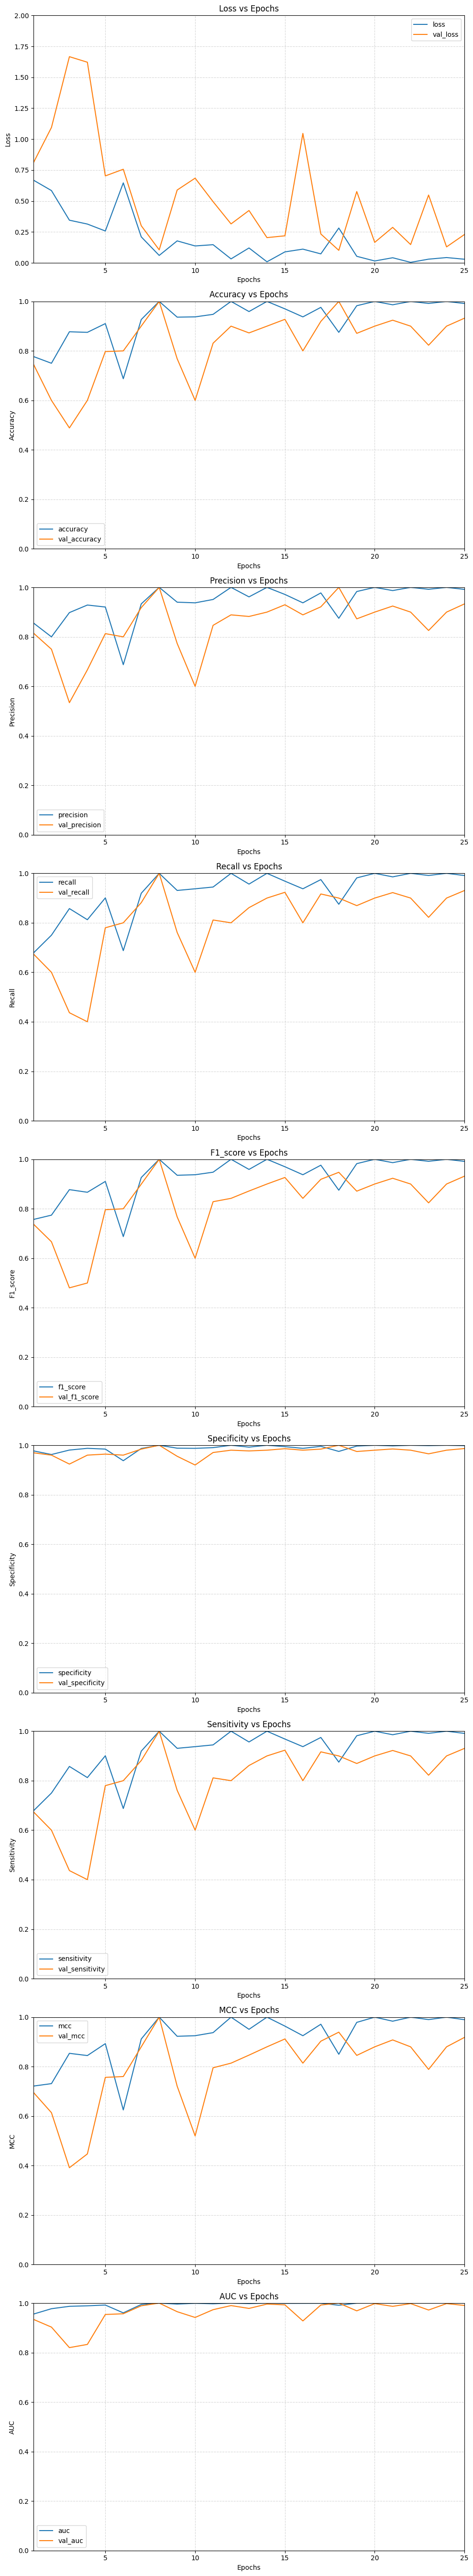

In [13]:
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
plot_metrics(history, metric_names)

In [ ]:
def confusion_matrix(true_labels, predicted_labels, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    np.add.at(cm, (true_labels, predicted_labels), 1)
    return cm

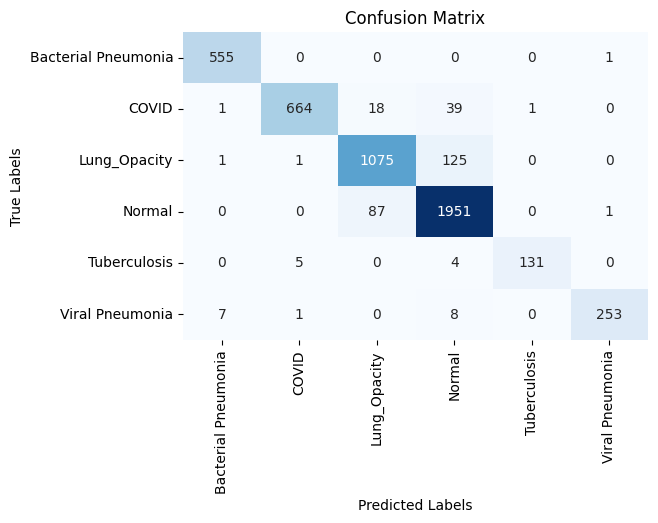

In [17]:
cm = confusion_matrix(true_labels, predicted_labels, 6)

classes = list(train_generator.class_indices.keys())

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()